# Project 5: Classifying Point Clouds with PointNet

For this project, we are going to build deep learning architectures to classify point clouds that were extracted from self-driving car LiDAR scans.

Basic learning objectives of this project:
* Construct the basic pipeline used for point cloud classification
* Analyze the results from our model and look for potential points of improvement
* Understand the limitations of the model and improve it using positional encodings

## Setup

In [58]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from vision.utils import verify

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
device = torch.device('cpu')
# If you have an NVIDIA GPU with at least 2 GB of VRAM, set this to True
use_cuda = False
# If you have an Apple Silicon Mac, set this to True
use_apple_silicon = False
if torch.cuda.is_available():
    if use_cuda:
        device = torch.device('cuda')
        print("CUDA-compatible NVIDIA GPU enabled.")
    else:
        print("CUDA-compatible NVIDIA GPU detected. Consider setting use_cuda to True.")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    if use_apple_silicon:
        device = torch.device('mps')
        print("Apple Silicon GPU enabled.")
    else:
        print("Apple Silicon GPU detected. Consider setting use_apple_silicon to True.")
        

print("Using device: %s" % str(device))

Apple Silicon GPU detected. Consider setting use_apple_silicon to True.
Using device: cpu


Lets take a second to visualize a few point clouds that we are going to train our model on. You might need to rotate the visualization before you can actually see the object being represented by the points. See if you can make out this pedestrian's arms, legs, and head.

In [6]:
from vision.utils import plot_cloud_from_file

plot_cloud_from_file('data/sweeps/PEDESTRIAN/11.txt')

## Part 1: Data Loading

The first order of business we're going to take care of is writing a PyTorch dataset that will load in the data we'll be using to train and test our model. We have a total of 20 different classes that all found under the `data/sweeps` folder and each class has been split into a training and testing set. We will write a class that will load the appropriate data given the split we pass in (i.e. train/test split).

**TODO 1:** complete `part1_dataloader.py`

In [7]:
from vision.part1_dataloader import Argoverse
from torch.utils.data import DataLoader
from tests.test_part1 import (
    test_dataset_length, 
    test_unique_values, 
    test_get_points_from_file, 
    test_pad_points, 
    test_class_values
)

In [8]:
print("test_dataset_length(): ", verify(test_dataset_length))
print("test_unique_values(): ", verify(test_unique_values))
print("test_get_points_from_file(): ", verify(test_get_points_from_file))
print("test_pad_points(): ", verify(test_pad_points))
print("test_class_values(): ", verify(test_class_values))

test_dataset_length():  "Correct"
test_unique_values():  "Correct"
test_get_points_from_file():  "Correct"
test_pad_points():  "Correct"
test_class_values():  "Correct"


Now we can load in our data. When extracting object point clouds from LiDAR scans, we pruned point clouds with large numbers of points to reduce the computational demand of training and testing our classifiers. We pruned all point clouds to have a maximum of 200 points so that is the size that we will be padding all of the other point clouds to. (Feel free to adjust the batch size if you find a value that works better with your implementation)

In [9]:
train_dataset = Argoverse('train', 'data/sweeps', 200)
test_dataset = Argoverse('test', 'data/sweeps', 200)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

## Part 2: Baseline

A very simple baseline to start with is a voxel-based approach. Our overall point cloud falls in a 4x4x4 meter volume in space. We can divide this up into 1x1x1 meter volumes which would give us a total of 64 $1m^3$ cells. We build a 64-dimensional feature for a point by simply counting how many points in the point cloud fall into each cell then normalizng the resulting feature vector.

For more details see the project pdf.

**TODO 2:** complete `part2_baseline.py`

In [217]:
from vision.part2_baseline import Baseline
from torch import optim
from vision.training import train, test
from tests.test_part2 import (
    test_count_points,
    test_baseline
)

In [218]:
print("test_count_points(): ", verify(test_count_points))
print("test_baseline(): ", verify(test_baseline))

test_count_points():  "Correct"
test_baseline():  "Correct"


Lets train our baseline implementation and see how it does! Fill in the hyperparameters and train your model. 

To get full credit for this section, you will need *$\geq$ 30%* accuracy on the test data set. The TAs were able to consistently achieve this accuracy with ~15 epochs.

*Hint: Play around with different voxel resolutions and the two different modes you implemented to see which configuration works the best.*

In [219]:
lr = 0.05
weight_decay = 1e-4
epochs = 10

model = Baseline(20, voxel_resolution=8, mode="occupancy")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [220]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader)

Epoch 1

Training...


100%|██████████| 213/213 [00:01<00:00, 188.17it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 224.51it/s]



Epoch 1 Stats:
	Training accuracy: 0.5782
	Training loss: 1.4724
	Validation accuracy: 0.4167
	Validation loss: 2.3490

Validation accuracy improved from 0 to 0.4166666567325592
Saving model to Baseline.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:00<00:00, 273.46it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 315.16it/s]



Epoch 2 Stats:
	Training accuracy: 0.7303
	Training loss: 0.8301
	Validation accuracy: 0.4617
	Validation loss: 2.3533

Validation accuracy improved from 0.4166666567325592 to 0.46166667342185974
Saving model to Baseline.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:00<00:00, 279.91it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 323.90it/s]



Epoch 3 Stats:
	Training accuracy: 0.7526
	Training loss: 0.7499
	Validation accuracy: 0.4400
	Validation loss: 2.6564


Epoch 4

Training...


100%|██████████| 213/213 [00:00<00:00, 290.38it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 295.02it/s]



Epoch 4 Stats:
	Training accuracy: 0.7568
	Training loss: 0.7133
	Validation accuracy: 0.4467
	Validation loss: 2.7011


Epoch 5

Training...


100%|██████████| 213/213 [00:00<00:00, 300.39it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 339.24it/s]



Epoch 5 Stats:
	Training accuracy: 0.7665
	Training loss: 0.6945
	Validation accuracy: 0.4483
	Validation loss: 2.9255


Epoch 6

Training...


100%|██████████| 213/213 [00:00<00:00, 296.98it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 331.34it/s]



Epoch 6 Stats:
	Training accuracy: 0.7676
	Training loss: 0.6805
	Validation accuracy: 0.4583
	Validation loss: 3.0457


Epoch 7

Training...


100%|██████████| 213/213 [00:00<00:00, 301.13it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 336.00it/s]



Epoch 7 Stats:
	Training accuracy: 0.7706
	Training loss: 0.6703
	Validation accuracy: 0.4433
	Validation loss: 3.1362


Epoch 8

Training...


100%|██████████| 213/213 [00:00<00:00, 275.28it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 321.62it/s]



Epoch 8 Stats:
	Training accuracy: 0.7759
	Training loss: 0.6279
	Validation accuracy: 0.4400
	Validation loss: 2.8697


Epoch 9

Training...


100%|██████████| 213/213 [00:00<00:00, 218.64it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 327.78it/s]



Epoch 9 Stats:
	Training accuracy: 0.7826
	Training loss: 0.6386
	Validation accuracy: 0.4667
	Validation loss: 2.6555

Validation accuracy improved from 0.46166667342185974 to 0.46666666865348816
Saving model to Baseline.pt


Epoch 10

Training...


100%|██████████| 213/213 [00:00<00:00, 277.01it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 323.89it/s]



Epoch 10 Stats:
	Training accuracy: 0.7603
	Training loss: 0.7051
	Validation accuracy: 0.4417
	Validation loss: 3.4117




In [221]:
model = torch.load('output/Baseline.pt')
test_acc, test_loss = test(model, test_loader)

/var/folders/zt/lq569kjj6f5f4wqklbbzk7r40000gn/T/ipykernel_28856/2856288945.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 38/38 [00:00<00:00, 314.28it

Test accuracy: 0.4667
Test loss: 2.7085


## Part 3: PointNet

Now that we have a baseline to compare to, we're going to build a simplified version of PointNet which was first published in 2017 by researchers at Stanford University. You can view the original website for this publication [here](https://stanford.edu/~rqi/pointnet/). 

We will be slightly modifying the original architecture. The architecture described in the PointNet publication includes two modules that we will not be implementing. Namely, they are the input transform and the feature transform. We will also not be using our PointNet implementation for semantic segmentation so you can ignore that part of the architecture as well. For an architecture diagram of what we will be implementing, check the project pdf.

**TODO 3**: complete `part3_pointnet.py`, use the architecture diagram in the project pdf for reference.

In [117]:
from tests.test_part3 import test_pointnet
from vision.part3_pointnet import PointNet

In [118]:
print("test_pointnet(): ", verify(test_pointnet))

test_pointnet():  "Correct"


Now that we have a PointNet implementation, lets train our model and see how it does. Fill in the hyper-parameters and give your new model a spin! 

To get full credit for this section, you will need *$\geq$ 60% accuracy* on the test dataset. The TAs were able to consistently achieve this accuracy with ~15 epochs of training.

In [119]:
lr = 0.001
weight_decay = 1e-4
epochs = 10

model = PointNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [120]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|██████████| 213/213 [00:04<00:00, 49.80it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 114.35it/s]



Epoch 1 Stats:
	Training accuracy: 0.4653
	Training loss: 1.6381
	Validation accuracy: 0.3917
	Validation loss: 1.7324

Validation accuracy improved from 0 to 0.3916666805744171
Saving model to PointNet.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:04<00:00, 51.20it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 149.84it/s]



Epoch 2 Stats:
	Training accuracy: 0.6071
	Training loss: 1.1721
	Validation accuracy: 0.4883
	Validation loss: 1.4406

Validation accuracy improved from 0.3916666805744171 to 0.4883333444595337
Saving model to PointNet.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:05<00:00, 37.38it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 111.29it/s]



Epoch 3 Stats:
	Training accuracy: 0.6682
	Training loss: 1.0213
	Validation accuracy: 0.4583
	Validation loss: 1.5717


Epoch 4

Training...


100%|██████████| 213/213 [00:04<00:00, 45.27it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 145.71it/s]



Epoch 4 Stats:
	Training accuracy: 0.6988
	Training loss: 0.9372
	Validation accuracy: 0.5433
	Validation loss: 1.3428

Validation accuracy improved from 0.4883333444595337 to 0.5433333516120911
Saving model to PointNet.pt


Epoch 5

Training...


100%|██████████| 213/213 [00:04<00:00, 51.21it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 137.76it/s]



Epoch 5 Stats:
	Training accuracy: 0.7276
	Training loss: 0.8528
	Validation accuracy: 0.5200
	Validation loss: 1.6250


Epoch 6

Training...


100%|██████████| 213/213 [00:04<00:00, 52.89it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 128.91it/s]



Epoch 6 Stats:
	Training accuracy: 0.7462
	Training loss: 0.7891
	Validation accuracy: 0.5800
	Validation loss: 1.3967

Validation accuracy improved from 0.5433333516120911 to 0.5799999833106995
Saving model to PointNet.pt


Epoch 7

Training...


100%|██████████| 213/213 [00:03<00:00, 53.34it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 142.73it/s]



Epoch 7 Stats:
	Training accuracy: 0.7524
	Training loss: 0.7586
	Validation accuracy: 0.5450
	Validation loss: 1.3778


Epoch 8

Training...


100%|██████████| 213/213 [00:04<00:00, 52.53it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 130.64it/s]



Epoch 8 Stats:
	Training accuracy: 0.7721
	Training loss: 0.7166
	Validation accuracy: 0.5333
	Validation loss: 1.5075


Epoch 9

Training...


100%|██████████| 213/213 [00:04<00:00, 51.79it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 138.25it/s]



Epoch 9 Stats:
	Training accuracy: 0.7782
	Training loss: 0.6841
	Validation accuracy: 0.6383
	Validation loss: 1.1725

Validation accuracy improved from 0.5799999833106995 to 0.6383333206176758
Saving model to PointNet.pt


Epoch 10

Training...


100%|██████████| 213/213 [00:04<00:00, 47.40it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 145.50it/s]


Epoch 10 Stats:
	Training accuracy: 0.7912
	Training loss: 0.6405
	Validation accuracy: 0.6233
	Validation loss: 1.1953




In [121]:
model = torch.load('output/PointNet.pt', map_location='cpu')
test_acc, test_loss = test(model, test_loader)

/var/folders/zt/lq569kjj6f5f4wqklbbzk7r40000gn/T/ipykernel_28856/2270301145.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 38/38 [00:00<00:00, 113.01it

Test accuracy: 0.6383
Test loss: 1.1754


## Part 4: Performance Analysis

Now that we have a trained PointNet model, we can look at how it performs and what its shortcomings are. We are also going to analyze our point clouds to see which parts of them the model deemed to be most important in making its classification decision.

**TODO 4:** complete `part4_analysis.py`

In [124]:
from vision.utils import (
    generate_and_plot_confusion_matrix,
    plot_crit_points_from_file
)
from tests.test_part4 import (
    test_critical_indices,
    test_critical_indices_with_duplicates,
    test_confusion_matrix,
    test_confusion_matrix_normalized
)

In [125]:
print("test_critical_indices(): ", verify(test_critical_indices))
print("test_critical_indices_with_duplicates(): ", verify(test_critical_indices_with_duplicates))
print("test_confusion_matrix(): ", verify(test_confusion_matrix))
print("test_confusion_matrix_normalized(): ", verify(test_confusion_matrix_normalized))

test_critical_indices():  "Correct"
test_critical_indices_with_duplicates():  "Correct"
test_confusion_matrix():  "Correct"
test_confusion_matrix_normalized():  "Correct"


Lets use the confusion matrix to look at which mistakes our model is making most often.

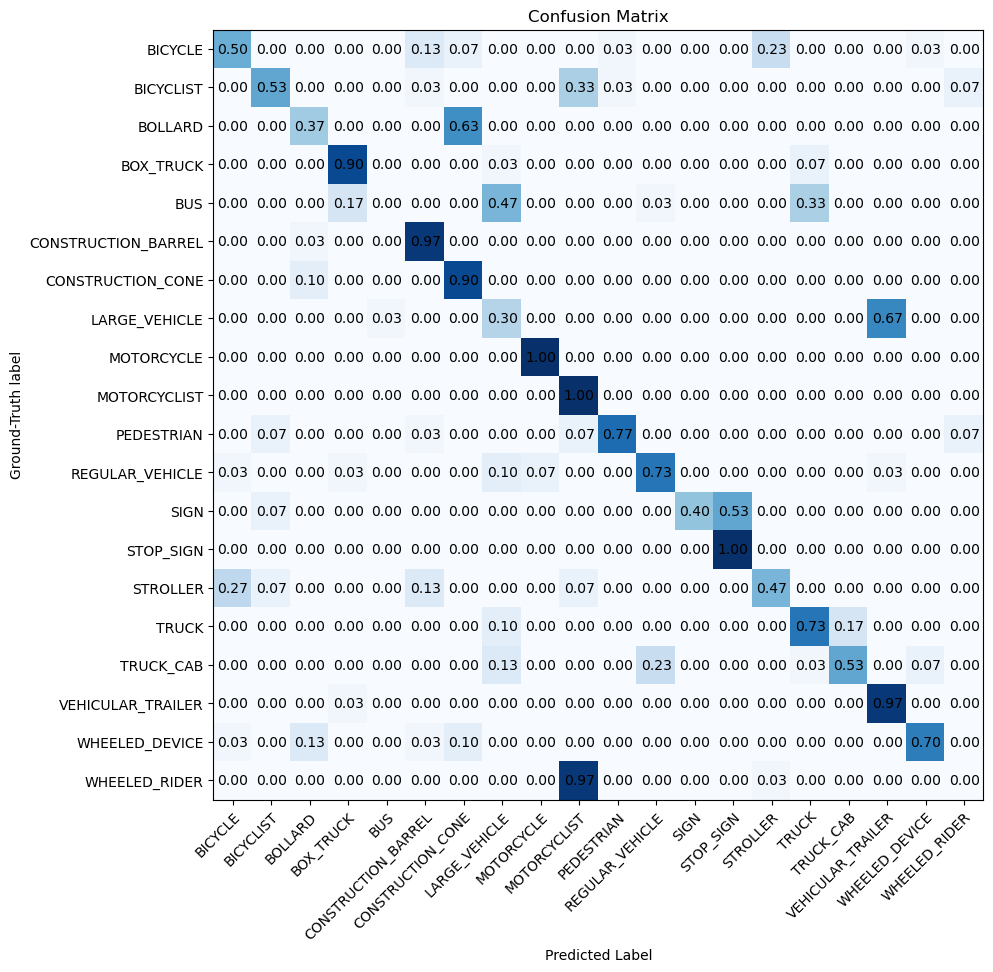

In [126]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

Now lets visualize the critical points calculated by our model for the predestrian clouds from before. Recall that these are the points that contributed to the global feature. Why do you think these were the critical points the model ended up using? (Feel free to use different point clouds for your analysis)

In [127]:
plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/11.txt', 200)

## Part 5: T-Net

Our basic PointNet model does pretty well. But let's see if we can do any better. One proposed solution to improve on the shortcomings of the basic PointNet model is using a T-Net (see pdf for more details). 

**TODO 5:** complete `part5_tnet.py`

In [215]:
from vision.part5_tnet import PointNetTNet
from tests.test_part5 import (
    test_tnet_shapes,
    test_pointnet_tnet
)

In [216]:
print("test_tnet_shapes(): ", verify(test_tnet_shapes))
print("test_pointnet_tnet(): ", verify(test_pointnet_tnet))

test_tnet_shapes():  "Correct"
test_pointnet_tnet():  "Correct"


Let's check out how our model performs now that we added a T-Net.

To get full credit for this section, you will need *$\geq$ 65% accuracy* on the test dataset. The TAs were able to consistently achieve this accuracy with ~10 epochs of training.

*Hint: You may need to play around with the number of layers in the T-Net*

In [ ]:
lr = 0.002
weight_decay = 1e-4
epochs = 10

model = PointNetTNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

In [ ]:
model = torch.load('output/PointNetTNet.pt', map_location='cpu')
test_acc, test_loss = test(model, test_loader)

Lets take a look at how the addition of positional encoding improved on the performance of our original PointNet model. Which classes does the positional encoding help the most with? Which ones does it not really seem to make much of a difference for? Why?

In [ ]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

In [ ]:
plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/11.txt', 200)